# RandomForestClassifier

In [1]:
# warningの無視
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split

# モデル
from sklearn.tree import DecisionTreeClassifier # 決定木に必要な関数
from sklearn.ensemble import RandomForestClassifier # ランダムフォレストに必要な関数
from sklearn.model_selection import GridSearchCV # グリッドサーチに必要な関数

# 評価指標
from sklearn import metrics # 精度検証に必要な関数
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score # 精度の確認 / 正解率
from sklearn.metrics import f1_score       #f1

# User defined functions
from self_lib import doggie_tail as d_
from self_lib import timer as t

# Jupyter上で図を表示するためのコマンド
%matplotlib inline

In [3]:
# pickleで読込む
import pickle

# 前処理済みデータ取得
with open('data/dataset/pre/pre_data.pickle','rb') as f:
    pre_data = pickle.load(f)

In [4]:
# 表示列数を指定
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### version setting

In [5]:
submitVer="_v05"
modelName="XGBoost"

In [6]:
featureName="All"

In [7]:
yName='LoanStatus'

In [8]:
# y
fileName="data.pickle"
with open("data/dataset/pre/" + "pre_y_data" + submitVer + ".pickle",'rb') as f:
    y = pickle.load(f)

In [9]:
#X
with open("data/dataset/pre/" + "pre_data.pickle",'rb') as f:
    pre_data = pickle.load(f)

In [10]:
# pred
with open("data/dataset/test/" + "test_data.pickle",'rb') as f:
    test_data = pickle.load(f)

In [11]:
d_.d(pre_data)

,LoanStatus,Term,Approval_Y,Approval_M,Disbursement_Y,Disbursement_M,TermFlg,RevLineCr,LowLoan,LoanAmount,BalanceGross,SystemCode,Employees,ExistNew,CreateJob,FranchiseCode,Zip,BankState,UrbanRural
count,255477.00,255477.00,255477.00,255477.00,254876.00,254876.00,255477.00,255477.00,255477.00,255477.00,255477.00,255477.00,255477.00,255431.00,255477.00,255477.00,255477.00,255477.00,255477.00
missing,0.00,0.00,0.00,0.00,601.00,601.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,46.00,0.00,0.00,0.00,0.00,0.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.19,111.43,2000.97,6.48,2001.25,6.35,0.27,0.93,1.12,189347.82,0.71,398211.51,11.17,0.28,0.23,0.04,54086.45,0.01,0.76
std,0.39,79.48,5.98,3.37,5.89,3.43,0.45,0.72,0.34,282409.05,206.61,261522.61,75.02,0.45,0.42,0.19,31237.00,0.11,0.64
min,0.00,0.00,1971.00,1.00,1971.00,1.00,0.00,0.00,0.00,1000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,60.00,1996.00,4.00,1997.00,4.00,0.00,0.00,1.00,35000.00,0.00,235310.00,2.00,0.00,0.00,0.00,28031.00,0.00,0.00
50%,0.00,84.00,2002.00,6.00,2003.00,6.00,0.00,1.00,1.00,85000.00,0.00,445310.00,4.00,0.00,0.00,0.00,55439.00,0.00,1.00


In [12]:
def importances(model):
    """ 変数重要度
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.barh(range(len(indices)), importances[indices] , align='center')
    plt.yticks(range(len(indices)), feature_X[indices])
    plt.title('decision tree feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('variable')
    plt.show()

In [13]:
pre_data=pre_data.fillna(pre_data.mean())

In [14]:
test_data=test_data.fillna(test_data.mean())

#### 分割

In [15]:
# 目的変数と説明変数の取得
y=pre_data['LoanStatus']
X=pre_data.drop(columns='LoanStatus')

In [16]:
# 変数重要度を見るため、変数名を取り出しておく
feature_X = X.columns
feature_y = y.name

In [17]:
# 訓練データとテストデータの分割
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, shuffle=True)

# 訓練データと検証データの分割
train_X, valid_X, train_y, valid_y = train_test_split(train_X, train_y, test_size=0.2, shuffle=True)

#### Grid_Search
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [18]:
"""ハイパーパラメータの max_depth(木の深さ), 
# n_estimators(決定木の数)に関してグリッドサーチを行う
# グリッドサーチに使用するパラメータの値を用意
"""
params = {
    'max_depth': [10, 20, 30],
    'n_estimators': [10, 100, 1000]}

In [19]:
# グリッドサーチを行う
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0), # 識別器
    param_grid=params, #　最適化したいパラメータセット
    n_jobs=1,
    cv=5,#　5分割交差検証
    scoring='f1',
    verbose=2)
grid.fit(train_X,  train_y) 

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=10, n_estimators=10; total time=   0.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=   0.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=   0.9s
[CV] END ......................max_depth=10, n_estimators=10; total time=   1.0s
[CV] END ......................max_depth=10, n_estimators=10; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   9.6s
[CV] END ....................max_depth=10, n_estimators=1000; total time= 1.6min
[CV] END ....................max_depth=10, n_esti

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=1,
             param_grid={'max_depth': [10, 20, 30],
                         'n_estimators': [10, 100, 1000]},
             scoring='f1', verbose=2)

In [20]:
# 最適解でモデルを作成
max_depth=grid.best_params_.get('max_depth')
n_estimators=grid.best_params_.get('n_estimators')
RFR_model = RandomForestClassifier(random_state=0, max_depth=max_depth, n_estimators=n_estimators)

In [21]:
# モデルの作成
RFR_model = RandomForestClassifier(random_state=0, max_depth=15)

In [22]:
# モデルの学習
RFR_model = RFR_model.fit(train_X, train_y)

In [23]:
# 学習データの予測
pred_train_y = RFR_model.predict(train_X)

In [24]:
# 評価データの予測
pred_test_y = RFR_model.predict(test_X)

In [25]:
# 精度の確認
accuracyScore = accuracy_score(test_y, pred_test_y)
f1Score=f1_score(test_y,pred_test_y)
print('accuracy_score:{0:.4f}'.format(accuracyScore))
print('f1_score:{0:.4f}'.format(f1Score))

accuracy_score:0.9445
f1_score:0.8474


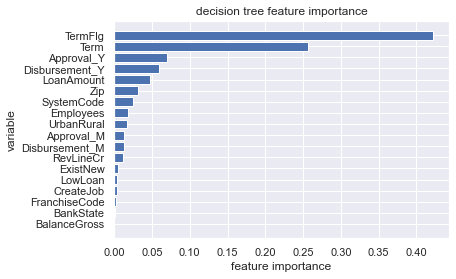

In [26]:
importances(RFR_model)

In [27]:
# モデルの保存
with open("stack/" + featureName + "_" + modelName + '_model.pickle', mode='wb') as f:
    pickle.dump(model, f)

NameError: name 'model' is not defined